# Optymalizatory w uczeniu głębokim

Optymalizator to algorytm, który aktualizuje wagi sieci na podstawie obliczonego gradientu, aby zminimalizować funkcję kosztu. W praktyce dobór optymalizatora ma duży wpływ na szybkość i stabilność treningu.

Funkcja kosztu (loss / cost function) to matematyczna miara błędu modelu — mówi, jak bardzo przewidywania różnią się od wartości oczekiwanych. Funkcja straty (loss function) zwykle odnosi się do błędu pojedynczej próbki, podczas gdy funkcja kosztu bywa rozumiana jako średnia strata dla całego batcha lub zbioru danych. Dzięki temu model wie, „w którą stronę” ma korygować swoje parametry podczas uczenia.

## Po co nam optymalizator?
- tłumaczy gradient (pochodną) na konkretną zmianę wag sieci,
- decyduje o kierunku i wielkości kroku (np. stała wartość * współczynnik uczenia),
- może akumulować historię gradientów, aby przyspieszyć uczenie w "trudnych" wymiarach,
- wyrównuje różnice skal między parametrami lub adaptuje się do zmiennego szumu w gradientach.


### **1. Metody pierwszego rzędu**

#### **SGD – Stochastic Gradient Descent (Stochastyczny spadek gradientu)**

Klasyczny optymalizator, który aktualizuje wagi, korzystając z gradientu obliczonego na małej losowej próbce (mini-batch). Jest prosty, stabilny i często działa świetnie przy dużych modelach i odpowiednim tuningu learning rate.

#### **SGD z momentum (np. Momentum, Nesterov Momentum)**

Dodaje „bezwładność” do ruchu po powierzchni funkcji kosztu – zamiast reagować tylko na aktualny gradient, wykorzystuje też poprzednie kroki. Dzięki temu szybciej pokonuje doliny i wolniej „gubi się” w płaskich regionach.

---

### **2. Metody adaptacyjne**

Optymalizatory, które dopasowują wartość learning rate osobno dla każdego parametru, na podstawie historii gradientów.

#### **AdaGrad – Adaptive Gradient Algorithm**

Zmniejsza krok uczenia dla parametrów, które często mają duży gradient; idealny, gdy niektóre cechy pojawiają się bardzo rzadko (np. w NLP). Problem: learning rate szybko spada do bardzo małych wartości.

#### **RMSProp – Root Mean Square Propagation**

Rozwiązuje problem AdaGrad — zamiast sumować wszystkie gradienty, używa wykładniczej średniej ruchomej. Dzięki temu learning rate nie gaśnie za szybko i pozostaje stabilny.

#### **Adam – Adaptive Moment Estimation**

Najpopularniejszy optymalizator. Łączy momentum (średnia gradientów) i adaptacyjne skalowanie kroku (średnia kwadratów gradientów). Działa dobrze „od strzału”, szybko się zbiega, jest stabilny i rzadko wymaga dużego tuningu.

---

## **3. Metody hybrydowe**

Optymalizatory łączące zalety momentum i adaptacyjnych kropli uczenia.

### **AdamW – Adam with Weight Decay**

Odmiana Adama z poprawnym *odseparowanym* wdrożeniem weight decay (regularizacji L2). W standardowym Adamie weight decay działał nieoptymalnie; AdamW znacząco poprawia generalizację i jest obecnie domyślnym wyborem w modelach głębokiego uczenia (np. Transformers).


In [21]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# Ustawiamy ziarno losowe, aby wszystkie eksperymenty były powtarzalne
torch.manual_seed(7)

# Generujemy prostą zależność liniową z szumem
total_points = 80
X = torch.linspace(-1.0, 1.0, steps=total_points).unsqueeze(1)
y = 2.5 * X - 0.4 + 0.45 * torch.randn_like(X)

# Wydzielamy mały zestaw walidacyjny, by obserwować przebieg strat
dev_split = int(0.75 * total_points)
train_X, val_X = X[:dev_split], X[dev_split:]
train_y, val_y = y[:dev_split], y[dev_split:]

mse_loss = nn.MSELoss()

# Pomocnicza funkcja do krótkiego podsumowania parametrów i błędu

def describe_model(model, label):
    with torch.no_grad():
        mse = mse_loss(model(X), y).item()
    w = model.weight.item()
    b = model.bias.item()
    print(f"{label}: w={w:.2f}, b={b:.2f}, MSE={mse:.4f}")

# Rysujemy oryginalne dane oraz linię wyuczoną przez model

def plot_regression(model, title):
    with torch.no_grad():
        preds = model(X).detach().numpy()
    plt.figure(figsize=(4.5, 3))
    plt.scatter(X.numpy(), y.numpy(), label='dane', s=12)
    plt.plot(X.numpy(), preds, color='tab:red', label='model')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Wykres przebiegu straty walidacyjnej

def plot_history(history, title):
    plt.figure(figsize=(4.5, 3))
    plt.plot(history, marker='o', linewidth=1)
    plt.title(title)
    plt.xlabel('Epoka')
    plt.ylabel('Strata walidacyjna')
    plt.tight_layout()
    plt.show()

# Uniwersalna funkcja trenująca dowolny optymalizator

def train_with(optimizer_factory, epochs=80):
    model = nn.Linear(1, 1)
    optimizer = optimizer_factory(model.parameters())
    history = []
    for _ in range(epochs):
        optimizer.zero_grad()
        preds = model(train_X)
        loss = mse_loss(preds, train_y)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            history.append(mse_loss(model(val_X), val_y).item())
    return model, history

## Przygotowanie danych i funkcji pomocniczych

## Klasyczny Stochastic Gradient Descent (SGD)

SGD aktualizuje wagi zgodnie z kierunkiem gradientu i zadaną szybkością uczenia. W wersji "batch" korzystamy z całości danych, ale idea jest ta sama: wykonujemy kroki w kierunku obniżenia straty.

Model po SGD: w=1.27, b=-0.82, MSE=0.7916


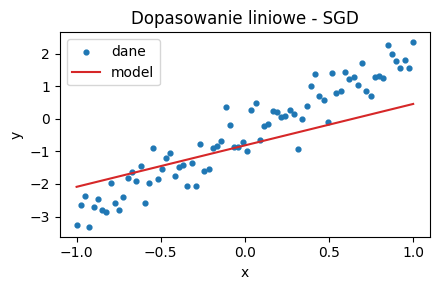

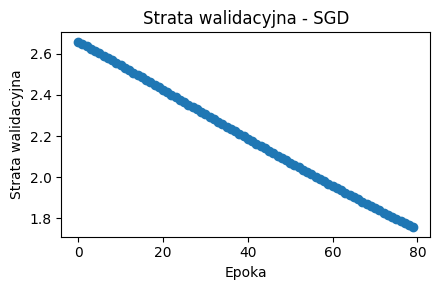

In [22]:
# Trening z klasycznym SGD i stałym learning rate
sgd_model, sgd_history = train_with(lambda params: torch.optim.SGD(params, lr=0.01), epochs=80)

describe_model(sgd_model, "Model po SGD")
plot_regression(sgd_model, "Dopasowanie liniowe - SGD")
plot_history(sgd_history, "Strata walidacyjna - SGD")

### Wnioski SGD
- Zbyt duży krok może powodować oscylacje; tutaj ustawiono umiarkowane `lr=0.1`, które stabilnie zbiega do minimum.
- SGD nie pamięta historii gradientów, więc może wymagać wielu epok przy bardziej złożonych powierzchniach błędu.

## SGD z momentum

Momentum kumuluje informację o poprzednich gradientach, co ułatwia pokonywanie płytszych dolin i przyspiesza zejście wzdłuż jednego kierunku. Formalnie przypomina ruch z bezwładnością.

Model po SGD+Momentum: w=2.40, b=-0.51, MSE=0.1945


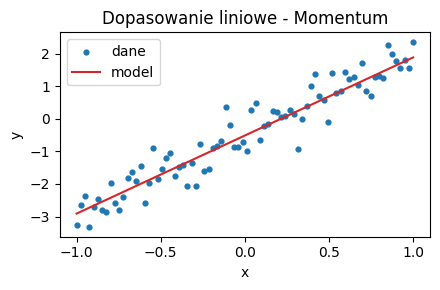

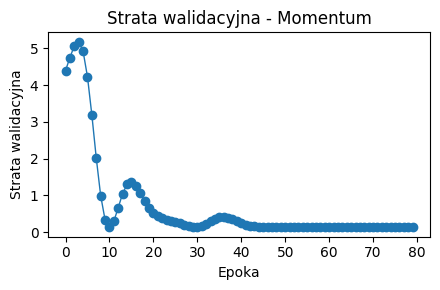

In [24]:
# SGD z momentum = 0.9 przy mniejszym learning rate
momentum_model, momentum_history = train_with(
    lambda params: torch.optim.SGD(params, lr=0.08, momentum=0.9),
    epochs=80
)

describe_model(momentum_model, "Model po SGD+Momentum")
plot_regression(momentum_model, "Dopasowanie liniowe - Momentum")
plot_history(momentum_history, "Strata walidacyjna - Momentum")

### Wnioski Momentum
- Zastosowanie `momentum=0.9` wygładza przebieg straty i ogranicza skoki, bo kolejne kroki uwzględniają kierunek z poprzednich iteracji.
- W zadaniach z szumem momentum często pozwala użyć większego kroku uczenia bez utraty stabilności.

## Adam

Adam (Adaptive Moment Estimation) adaptuje krok osobno dla każdego parametru i łączy to z momentum pierwszego i drugiego rzędu. Dzięki temu szybko dostosowuje się do skal gradientów.

Model po Adamie: w=2.33, b=-0.50, MSE=0.1978


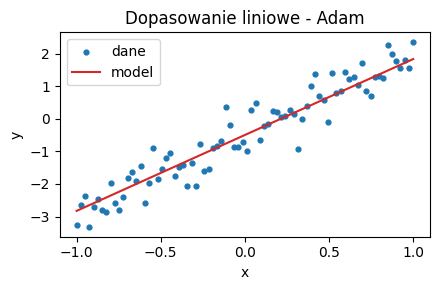

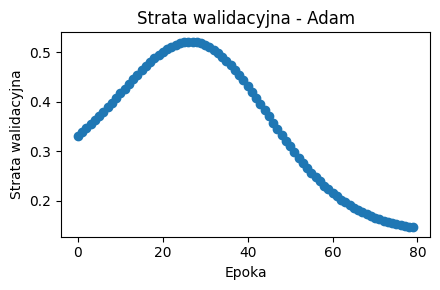

In [25]:
# Adam adaptuje krok dla każdego parametru osobno
adam_model, adam_history = train_with(
    lambda params: torch.optim.Adam(params, lr=0.05, betas=(0.9, 0.999)),
    epochs=80
)

describe_model(adam_model, "Model po Adamie")
plot_regression(adam_model, "Dopasowanie liniowe - Adam")
plot_history(adam_history, "Strata walidacyjna - Adam")

### Wnioski Adam
- Adam szybko osiąga niski błąd nawet przy dość dużym learning rate, bo skaluje krok według zmienności gradientu.
- Dobrze sprawdza się w zadaniach NLP/CV, ale czasem wymaga `weight_decay` lub restartu, by uniknąć zbyt dużej adaptacji.

## RMSProp

RMSProp kontroluje krok uczenia poprzez dzielenie gradientu przez średnią ważoną historycznych kwadratów gradientu. Sprzyja to stabilności w sytuacjach, gdy gradient jest różnie skalowany w poszczególnych wymiarach.

Model po RMSProp: w=2.42, b=-0.49, MSE=0.1923


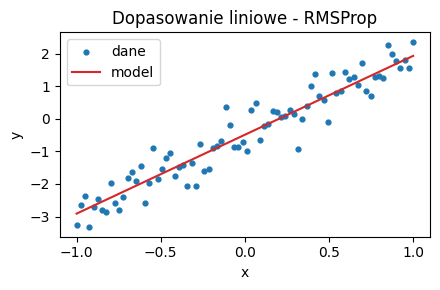

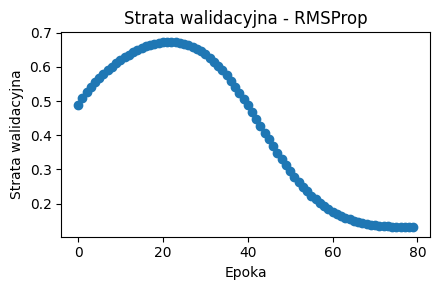

In [26]:
# RMSProp z lekkim tłumieniem (alpha=0.9)
rms_model, rms_history = train_with(
    lambda params: torch.optim.RMSprop(params, lr=0.05, alpha=0.9),
    epochs=80
)

describe_model(rms_model, "Model po RMSProp")
plot_regression(rms_model, "Dopasowanie liniowe - RMSProp")
plot_history(rms_history, "Strata walidacyjna - RMSProp")

### Wnioski RMSProp
- RMSProp, podobnie jak Adam, adaptuje krok uczenia, ale bez dodatkowego momentum drugiego rzędu, więc często jest nieco "wolniejszy", za to bardziej stabilny.
- Dobrze działa w sieciach rekurencyjnych, bo ogranicza wzrost gradientów na długich sekwencjach.